## Preprocessing and Training

### Table of Contents<a id='contents'>

* [Introduction](#introduction)
* [Libraries that will be used](#libraries_used)
* [Load the dataset](#load_the_dataset)
* [Minimal EDA](#minimal_eda)
    * [Proportion of target column classes Before Train test split](#target_column_before_ttsplit)
    * [Columns for preprocessing](#columns_of_interest)
    * [Train Test Split](#train_test_split)
    * [Proportion of target column in train set After Train test split](#target_column_after_ttsplit)
    * [Proportion of Target columns in test set After train_test_split](#target_testset_column_after_ttsplit)
* [Three Class Classification](#multiclass_classification) 
    * [TF-IFD](#tf_ifd)
        * [Define tokenize and stem function](#tokenize_stem_func)
    * [Fitting LogisticRegression(multi-class-ovr)](#fitting_logistic_regression_ovr)
      * [Three-Class Text Predictions for a given text](#3_class_text_predictions)
    * [AUC-ROC for Multiclass classification](#aucroc_multi)
        * [AUC-ROC Score for the multiclass problem](#auc_score_multiclass)
* [Binary Classification](#binary_classification)
    * [Binary Classification - Proportion of Target classes before train test split](#dist_bin_target_before)
    * [Binary Classification- Proportion of Target classes after train_test_split](#bi_target_column_after_ttsplit)
         * [Binary Classification Report for training set](#binary_class_report_training)
         * [Binary Classification Report for test set](#binary_class_report_test)
    * [AUC-ROC for Binary Classification](#aucroc_binary)
        * [Area under ROC score for the Binary problem](#auc_score_binaryclass)
* [SUMMARIZED CLASSIFICATION REPORTS(Multi-class and Binary class)](#summary_reports)
* [Summary](#Summary)

### Introduction<a id='introduction'>
    

After having completed the data wrangling and elaborate EDA on Yelp reviews and yelp business dataset, I have cp2_sentiment_df which focusses only on philadelphia restaurants and are in top 20 most popularly reviewed. Goal is to analyse the reviews and eventaully build a model so it can recommend customers with restaurants among top 20 which are mostly located in central part of philadelphia and also model will help the lower ranked restaurants to improve their businesse based on these user's sentiments. 

In [1]:
%matplotlib inline
#
# data manipulation and math
#
import numpy as np
import scipy as sp
import pandas as pd
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
import nltk
# Remove tokens that do not contain any letters from words_tokenized
import re
from nltk.stem.snowball import SnowballStemmer
# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# multi-class classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#
print("Loaded Libraries")
import warnings
warnings.simplefilter("ignore")

Loaded Libraries


#### set some options in Jupyter and for Matplotlib, Pandas and Seaborn

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#
plt.rcParams['figure.figsize'] = (3, 3)
plt.style.use('seaborn-pastel')
plt.rcParams['figure.dpi'] = 150      
#
c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]
#
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#

### Load the dataset<a id='load_the_dataset'>

In [3]:
dflog_main = pd.read_csv('cp2_sentiment_df.csv')

In [4]:
print('The data has ', dflog_main.shape[0], ' rows and ', dflog_main.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(dflog_main.columns)))

The data has  19697  rows and  21  columns

column names: 

business_id
name
address
city
state
postal_code
latitude
longitude
review_count
categories
review_id
user_id
yelp_review_stars
useful
funny
cool
text
date
year
text_length
target


### Minimal EDA<a id='minimal_eda'>

In [5]:
dflog_main.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,categories,review_id,user_id,yelp_review_stars,useful,funny,cool,text,date,year,text_length,target
0,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eastern, Specialty Food, American (New), Parks, Cafes, Food, Nightlife, Restaurants, Coffee & Tea, Lebanese",WeTHLEdLdP3Y3AXWWCsx4g,UizCd11Qoo74BKARrZp7HA,5,0,0,1,"We are visiting in Philadelphia from California. My son took us here for our 28 year wedding anniversary. All the food was delicious and the service was great! Everyone that worked there seemed happy to be there and we're extremely friendly! The pita bread was baked to order and served directly from the oven to the table and was by far, the best I'd had. The hummus, tabbouleh and marinated veggies were all Amazing! The grilled mixed mushrooms and lamb sausage were so flavorful! We didn't have anything that wasn't delicious! If I ever come back to Philly, I would definitely go back to this place! SO GOOD!!",2018-05-28 21:27:38,2018,614,0
1,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eastern, Specialty Food, American (New), Parks, Cafes, Food, Nightlife, Restaurants, Coffee & Tea, Lebanese",MrWpfvjVA6Qtj3CDvFfPiA,49aswoS-d09tyWNJimzZ5A,5,1,0,0,"Delicious food ! I personally loved it !!!\n\nI was surprised to see 3-star reviews here but when I read it I understood the reason . Everyone loved the place, the food but the prices. Let me tell you something. If I don't want to spend $200 for dinner I don't go to Barkley Prime! If I want to get a good quality lunch I don't expect it to be less than $25. Unfortunately life is expensive here in Philadelphia, especially for people with good tastes. And yes you have to pay $$$ for a good quality meals. So If you are aware of that I'm sure you will totally enjoy SURAYA",2018-02-01 19:28:41,2018,573,0
2,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eastern, Specialty Food, American (New), Parks, Cafes, Food, Nightlife, Restaurants, Coffee & Tea, Lebanese",hll3PKZbMbu2W7uFbF8ezQ,CmLK8cjvcUIKyNVMp8ZyDA,2,0,0,0,Beautiful place. Excellent food. I only gave it a 2 because they gouge you on the drinks. My manhattan was $16. A very small glass of house wine was $11.50. There is no justification for that. We eat out often in good restaurants. This is the only place that gouges you on the drinks.\nI got the halibut. It was delicious but quite small with nothing on the side.,2018-08-24 13:30:41,2018,362,1
3,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eastern, Specialty Food, American (New), Parks, Cafes, Food, Nightlife, Restaurants, Coffee & Tea, Lebanese",Mi5lScAdCWuJZj0QO_4qxg,wG77jgwRg53rN1KVxo637w,2,0,0,0,"It's extremely overpriced, and the sandwiches are a joke. I love Mediterranean cuisine but this is one of the worst i had. In a city with so many places to eat, i'd expect they would try harder.\n\nService is excellent, though. And the place is really nice",2018-02-11 18:04:01,2018,254,1
4,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eastern, Specialty Food, American (New), Parks, Cafes, Food, Nightlife, Restaurants, Coffee & Tea, Lebanese",SSu94Tvc6L5UBC4FDDyAbw,5s0nTuLRm3ue4Qfrj9PHkQ,5,0,0,0,"Instagram worthy and Claire is an amazing server! \n\nSuraya is super beautiful guys. Nice open space, ceramic tiles, and orange infused water. You enter straight into their bakery/cafe where you can order and sit or you can walk past a little and be seated in their restaurant. I recommend making a reservation because it can get pretty crowded. Afte

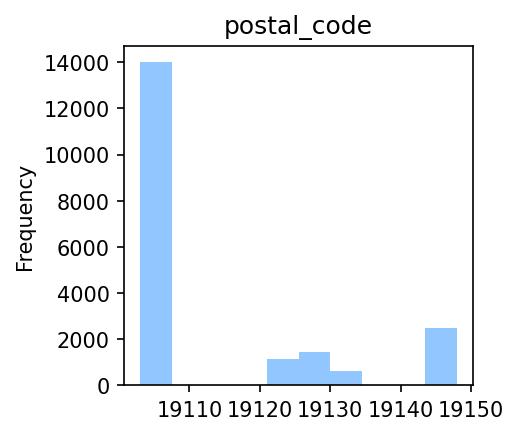

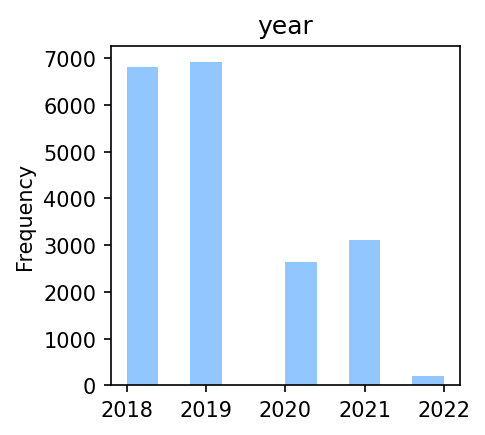

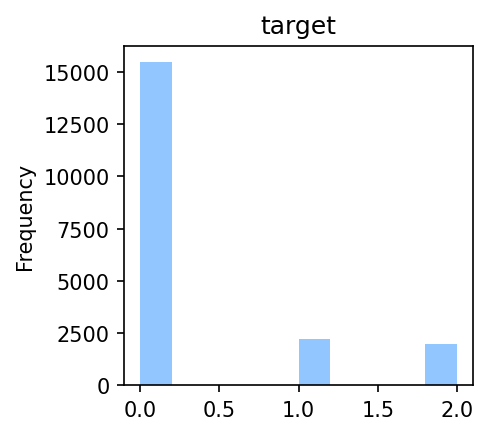

In [6]:
for col in list(dflog_main[['postal_code','year','target']]):
    dflog_main[col].plot(kind = 'hist', title = col)
    plt.show()

### One Interesting observation that i noted is more distribution in 2018 and 2019 and less in 2020 and 2021 and very less in 2022. Less numbers in 2020 and 2021 could be because of <font color='red'>COVID pandemic</font>? 2022, not much of data available yet. 

In [7]:
dflog_main.shape

(19697, 21)

In [8]:
#no. columns
dflog_main.shape[1]

21

In [9]:
#number of records:
dflog_main.shape[0]

19697

### Proportion of target column classes Before train_test_split<a id='target_column_before_ttsplit'>
##### <p style=text-align:left>* [Back to Contents](#contents)</p>

In [10]:
class_counts = dflog_main['target'].value_counts()
class_counts

0    15484
1     2238
2     1975
Name: target, dtype: int64

In [11]:
type(class_counts)

pandas.core.series.Series

In [12]:
class_percentages = pd.Series([(x / dflog_main.shape[0]) * 100.00 for x in class_counts])
class_percentages

0    78.610956
1    11.362136
2    10.026908
dtype: float64

Now we can use the percentages as labels and plot the distribution of the three classes:

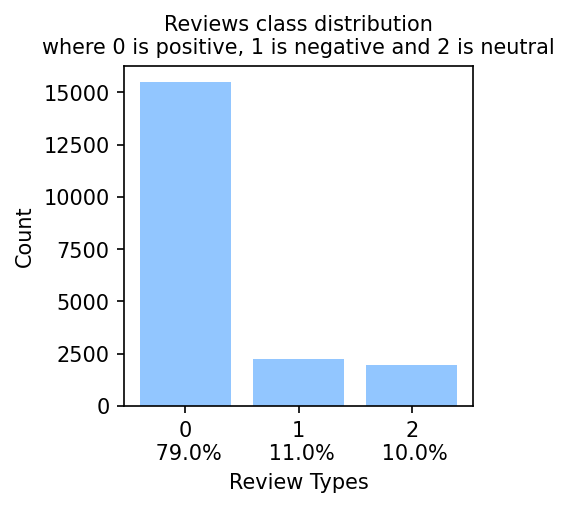

In [13]:
fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(class_percentages.index.astype(str) + '\n' + ' ' +
                   class_percentages.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Review Types')
ax.set_title('Reviews class distribution\nwhere 0 is positive, 1 is negative and 2 is neutral',
              fontsize = 10)
plt.show()

Target column has three unique values 0,1,2.

* 0 means positive - 4 star and 5 star
* 1 means negative- 1 star and 2 star
* 2 means neutral - 3 star

### Columns for Preprocessing<a id='columns_of_interest'>

In [14]:
# Picking the only text and target column
df_final = dflog_main[['text','target']]

In [15]:
df_final.head(3)

,text,target
0,"We are visiting in Philadelphia from California. My son took us here for our 28 year wedding anniversary. All the food was delicious and the service was great! Everyone that worked there seemed happy to be there and we're extremely friendly! The pita bread was baked to order and served directly from the oven to the table and was by far, the best I'd had. The hummus, tabbouleh and marinated veggies were all Amazing! The grilled mixed mushrooms and lamb sausage were so flavorful! We didn't have anything that wasn't delicious! If I ever come back to Philly, I would definitely go back to this place! SO GOOD!!",0
1,"Delicious food ! I personally loved it !!!\n\nI was surprised to see 3-star reviews here but when I read it I understood the reason . Everyone loved the place, the food but the prices. Let me tell you something. If I don't want to spend $200 for dinner I don't go to Barkley Prime! If I want to get a good quality lunch I don't expect it to be less than $25. Unfortunately life is expensive here in Philadelphia, especially for people with good tastes. And yes you have to pay $$$ for a good quality meals. So If you are aware of that I'm sure you will totally enjoy SURAYA",0
2,Beautiful place. Excellent food. I only gave it a 2 because they gouge you on the drinks. My manhattan was $16. A very small glass of house wine was $11.50. There is no justification for that. We eat out often in good restaurants. This is the only place that gouges you on the drinks.\nI got the halibut. It was delicious but quite small with nothing on the side.,1


### Clean up the text before train_test_split

In [16]:
import re 
def function_clean(text):
    text = re.sub(r"http\S+", "", text) #removing the URL Http
    # Removal of mentions
    text = re.sub("@[^\s]*", "", text)
    # Removal of hashtags
    text = re.sub("#[^\s]*", "", text)
    # Removal of numbers
    text = re.sub('[0-9]*[+-:]*[0-9]+', '', text)
    text = re.sub("(\\d|\\W)+"," ",text)
    text = re.sub("'s", "", text)   
    return text

In [17]:
# applying the cleaning function to text column
df_final['text'] = df_final['text'].apply(lambda text: function_clean(text))

In [18]:
df_final.head(3)

,text,target
0,We are visiting in Philadelphia from California My son took us here for our year wedding anniversary All the food was delicious and the service was great Everyone that worked there seemed happy to be there and we re extremely friendly The pita bread was baked to order and served directly from the oven to the table and was by far the best I d had The hummus tabbouleh and marinated veggies were all Amazing The grilled mixed mushrooms and lamb sausage were so flavorful We didn t have anything that wasn t delicious If I ever come back to Philly I would definitely go back to this place SO GOOD,0
1,Delicious food I personally loved it I was surprised to see star reviews here but when I read it I understood the reason Everyone loved the place the food but the prices Let me tell you something If I don t want to spend for dinner I don t go to Barkley Prime If I want to get a good quality lunch I don t expect it to be less than Unfortunately life is expensive here in Philadelphia especially for people with good tastes And yes you have to pay for a good quality meals So If you are aware of that I m sure you will totally enjoy SURAYA,0
2,Beautiful place Excellent food I only gave it a because they gouge you on the drinks My manhattan was A very small glass of house wine was There is no justification for that We eat out often in good restaurants This is the only place that gouges you on the drinks I got the halibut It was delicious but quite small with nothing on the side,1


The columns that we are really required for preprocessing are basically 'text' and 'target'.

I will extract the dependent (Y) and independent(X) variables from this data which are basically df_final.target and df_final.text

### Train Test Split<a id='train_test_split'>

In [20]:
y=df_final['target']

In [21]:
X_train,X_test,y_train,y_test=train_test_split(df_final['text'], df_final['target'], random_state=2,test_size=0.2, stratify = df_final['target'])

In [22]:
type(X_train),type(X_test), type(y_train),type(y_test)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [23]:
print("x_train shape :",X_train.shape)
print("x_test shape  :",X_test.shape)
print("y_train shape :",y_train.shape)
print("y_test shape  :",y_test.shape)

x_train shape : (15757,)
x_test shape  : (3940,)
y_train shape : (15757,)
y_test shape  : (3940,)


### Proportion of Target columns in train set After train_test_split<a id='target_column_after_ttsplit'>
##### <p style=text-align:left>* [Back to Contents](#contents)</p>

In [24]:
train_target_class_counts= y_train.value_counts()
train_target_class_counts

0    12387
1     1790
2     1580
Name: target, dtype: int64

In [25]:
type(train_target_class_counts)

pandas.core.series.Series

In [26]:
y_train.shape[0]

15757

In [27]:
train_target_class_percentages = pd.Series([(x / y_train.shape[0]) * 100.00 for x in train_target_class_counts])
train_target_class_percentages

0    78.612680
1    11.360030
2    10.027289
dtype: float64

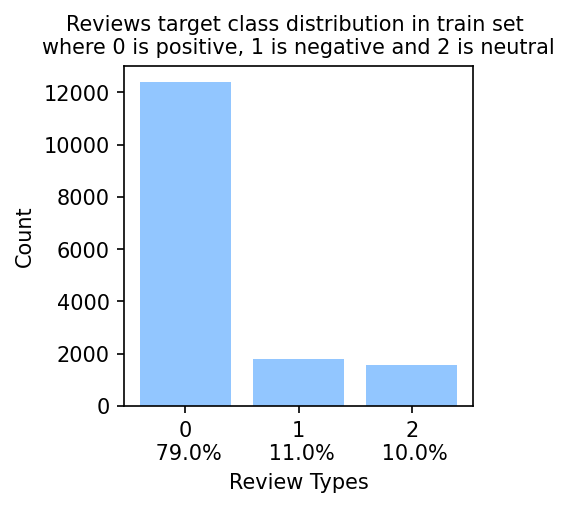

In [28]:
fig, ax = plt.subplots()
ax.bar(train_target_class_counts.index, train_target_class_counts)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(train_target_class_percentages.index.astype(str) + '\n' + ' ' +
                   train_target_class_percentages.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Review Types')
ax.set_title('Reviews target class distribution in train set \nwhere 0 is positive, 1 is negative and 2 is neutral',
              fontsize = 10)
plt.show()

### Proportion of Target columns in test set After train_test_split<a id='target_testset_column_after_ttsplit'>
##### <p style=text-align:left>* [Back to Contents](#contents)</p>

In [29]:
test_target_class_counts= y_test.value_counts()
test_target_class_counts

0    3097
1     448
2     395
Name: target, dtype: int64

In [30]:
type(test_target_class_counts)

pandas.core.series.Series

In [31]:
y_test.shape[0]

3940

In [32]:
test_target_class_percentages = pd.Series([(x / y_test.shape[0]) * 100.00 for x in test_target_class_counts])
test_target_class_percentages

0    78.604061
1    11.370558
2    10.025381
dtype: float64

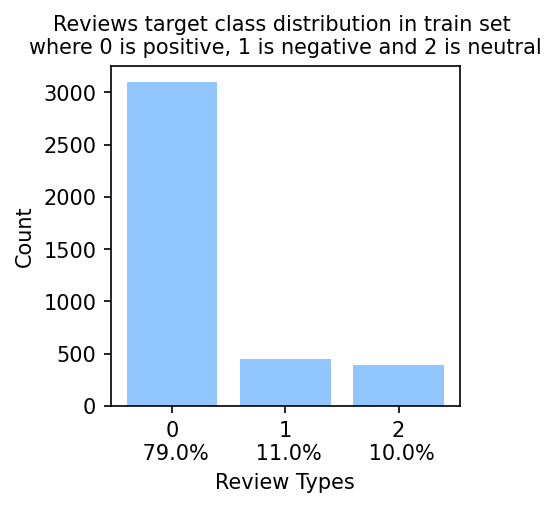

In [33]:
fig, ax = plt.subplots()
ax.bar(test_target_class_counts.index, test_target_class_counts)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(test_target_class_percentages.index.astype(str) + '\n' + ' ' +
                   test_target_class_percentages.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Review Types')
ax.set_title('Reviews target class distribution in train set \nwhere 0 is positive, 1 is negative and 2 is neutral',
              fontsize = 10)
plt.show()

### Term Frequency-Inverse Document Frequency(TF-IFD)<a id='tf_ifd'>
##### <p style=text-align:left>* [Back to Contents](#contents)</p>

Machine learning algorithms require inputs to be in numeric form and since our data has textual information and my goal is to build a classification model where the input will be a numeric representation of all the reviews and each review will have a label of either a 0,1,or 2. There are few vectorization techniques and I will use Term Frequency-Inverse Document Frequency (TF-IDF)  vectorization as this has the capability to capture better information than CountVecotorizer.  

Consider the word 'the'. It appears quite frequently in almost all review texts and will have a high count in each case. But obviously, it isn't the comment of all the reviews! Term Frequency-Inverse Document Frequency (TF-IDF) is one method which overcomes the shortcomings of CountVectorizer. The Term Frequency of a word is the measure of how often it appears in a document, while the Inverse Document Frequency is the parameter which reduces the importance of a word if it frequently appears in several documents.

### Define tokenize and stem function<a id='tokenize_stem_func'>

In [34]:
# Define a function to perform both stemming and tokenization


def tokenize_and_stem(text):

    tokens = [y for x in nltk.sent_tokenize(text) for y in nltk.word_tokenize(x)]

    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]',token)]

    stems = [stemmer.stem(token) for token in filtered_tokens]

    return stems

words_stemmed = tokenize_and_stem(dflog_main['text'][1])
print(words_stemmed)

['delici', 'food', 'i', 'person', 'love', 'it', 'i', 'was', 'surpris', 'to', 'see', '3-star', 'review', 'here', 'but', 'when', 'i', 'read', 'it', 'i', 'understood', 'the', 'reason', 'everyon', 'love', 'the', 'place', 'the', 'food', 'but', 'the', 'price', 'let', 'me', 'tell', 'you', 'someth', 'if', 'i', 'do', "n't", 'want', 'to', 'spend', 'for', 'dinner', 'i', 'do', "n't", 'go', 'to', 'barkley', 'prime', 'if', 'i', 'want', 'to', 'get', 'a', 'good', 'qualiti', 'lunch', 'i', 'do', "n't", 'expect', 'it', 'to', 'be', 'less', 'than', 'unfortun', 'life', 'is', 'expens', 'here', 'in', 'philadelphia', 'especi', 'for', 'peopl', 'with', 'good', 'tast', 'and', 'yes', 'you', 'have', 'to', 'pay', 'for', 'a', 'good', 'qualiti', 'meal', 'so', 'if', 'you', 'are', 'awar', 'of', 'that', 'i', "'m", 'sure', 'you', 'will', 'total', 'enjoy', 'suraya']


In [35]:
# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text

tfidf = TfidfVectorizer(stop_words='english',tokenizer=tokenize_and_stem,ngram_range=(1,1))

In [36]:
X_train_transformed = tfidf.fit_transform(X_train)


In [37]:
type(X_train_transformed)

scipy.sparse.csr.csr_matrix

In [39]:
X_test_transformed = tfidf.transform(X_test)

In [41]:
type(X_test_transformed)

scipy.sparse.csr.csr_matrix

### Fitting LogisticRegression With multi-class One versus Rest<a id='fitting_logistic_regression_ovr'>
##### <p style=text-align:left>* [Back to Contents](#contents)</p>

In [45]:
# Fitting Logistic regression to the training set
logreg = LogisticRegression(multi_class='ovr')
logreg.fit(X_train_transformed, y_train)

# Predicting the test set results
y_pred_train_logreg = logreg.predict(X_train_transformed)
y_pred_logreg = logreg.predict(X_test_transformed)

# Training score
print(f"Score on training set: {logreg.score(X_train_transformed,y_train)}")
print(f"Score on test set: {logreg.score(X_test_transformed,y_test)}")

Score on training set: 0.885955448372152
Score on test set: 0.8634517766497461


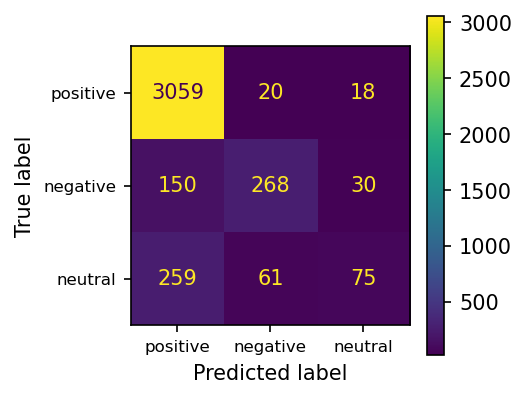

In [44]:
cm = confusion_matrix(y_test, y_pred_logreg, labels = logreg.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['positive', 'negative','neutral'])
ax.set_xticks([0, 1,2])
ax.set_yticks([0, 1,2])
ax.set_xticklabels(labels = ['positive', 'negative','neutral'], fontsize = 8)
ax.set_yticklabels(labels = ['positive', 'negative','neutral'], fontsize = 8)
display_cm.plot(ax = ax)

In [46]:
print(classification_report(y_train, y_pred_train_logreg))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     12387
           1       0.86      0.71      0.78      1790
           2       0.76      0.25      0.38      1580

    accuracy                           0.89     15757
   macro avg       0.84      0.65      0.70     15757
weighted avg       0.88      0.89      0.87     15757



In [47]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      3097
           1       0.77      0.60      0.67       448
           2       0.61      0.19      0.29       395

    accuracy                           0.86      3940
   macro avg       0.75      0.59      0.63      3940
weighted avg       0.84      0.86      0.84      3940



### Three Class Text Predictions<a id='3_class_text_predictions'>

In [48]:
print(logreg.predict(tfidf.transform(['Greek salad was so tasty,I loved it'])))

[0]


In [49]:
print(logreg.predict(tfidf.transform(['Food was bad'])))

[1]


In [50]:
print(logreg.predict(tfidf.transform(['Food was ok.'])))

[2]


In [51]:
print(logreg.predict(tfidf.transform(['Ambience was too noisy and chaotic'])))

[0]


### AUC-ROC for Multi-Class Classification<a id='aucroc_multi'>
                         
##### <p style=text-align:left>* [Back to Contents](#contents)</p>

AUC-ROC for multiclass classification by using the One vs All technique.

So, if we have three classes 0, 1, and 2, the ROC for class 0 will be generated as classifying 0 against not 0, i.e. 1 and 2. The ROC for class 1 will be generated as classifying 1 against not 1, and so on.

The ROC curve for multi-class classification models can be determined as below:

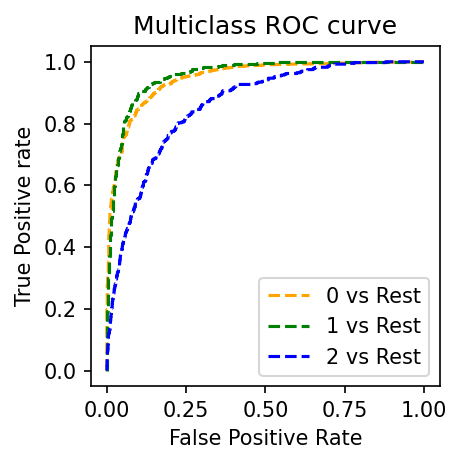

In [52]:
# fit model
clf1 = OneVsRestClassifier(LogisticRegression())
clf1.fit(X_train_transformed,y_train) 
pred = clf1.predict(tfidf.transform(X_test))
pred_prob = clf1.predict_proba(tfidf.transform(X_test))


# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

### Area under ROC score for the multiclass problem<a id='auc_score_multiclass'>

In [53]:
macro_roc_auc_ovr = roc_auc_score(y_test, pred_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, pred_prob, multi_class="ovr", average="weighted"
)

print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-Rest ROC AUC scores:
0.921643 (macro),
0.939873 (weighted by prevalence)


## Binary Classification<a id='binary_classification'>                          
##### <p style=text-align:left>* [Back to Contents](#contents)</p>

#### We will have two classes: positive (with value of 0), and not positive( with value of 1)

I will be converting the current target value of 2 which was neutral in the aboove three-class classification to positive class.


### Load the original dataset so i can make two classes instead of three

In [54]:
dflog_2_main = pd.read_csv('cp2_ppt_2_sentiment_df.csv')

In [55]:
print('The data has ', dflog_2_main.shape[0], ' rows and ', dflog_2_main.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(dflog_2_main.columns)))

The data has  19697  rows and  20  columns

column names: 

business_id
name
address
city
state
postal_code
latitude
longitude
review_count
categories
review_id
user_id
yelp_review_stars
useful
funny
cool
text
date
year
text_length


In [56]:
# Create new column "Target" that stored 0's or 1's. 0 being Positive, 1 being Non-Positive
dflog_2_main["target"] = np.where(dflog_2_main["yelp_review_stars"] >= 3, 0, 1)
dflog_2_main.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,categories,review_id,user_id,yelp_review_stars,useful,funny,cool,text,date,year,text_length,target
0,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eastern, Specialty Food, American (New), Parks, Cafes, Food, Nightlife, Restaurants, Coffee & Tea, Lebanese",WeTHLEdLdP3Y3AXWWCsx4g,UizCd11Qoo74BKARrZp7HA,5,0,0,1,"We are visiting in Philadelphia from California. My son took us here for our 28 year wedding anniversary. All the food was delicious and the service was great! Everyone that worked there seemed happy to be there and we're extremely friendly! The pita bread was baked to order and served directly from the oven to the table and was by far, the best I'd had. The hummus, tabbouleh and marinated veggies were all Amazing! The grilled mixed mushrooms and lamb sausage were so flavorful! We didn't have anything that wasn't delicious! If I ever come back to Philly, I would definitely go back to this place! SO GOOD!!",2018-05-28 21:27:38,2018,614,0
1,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eastern, Specialty Food, American (New), Parks, Cafes, Food, Nightlife, Restaurants, Coffee & Tea, Lebanese",MrWpfvjVA6Qtj3CDvFfPiA,49aswoS-d09tyWNJimzZ5A,5,1,0,0,"Delicious food ! I personally loved it !!!\n\nI was surprised to see 3-star reviews here but when I read it I understood the reason . Everyone loved the place, the food but the prices. Let me tell you something. If I don't want to spend $200 for dinner I don't go to Barkley Prime! If I want to get a good quality lunch I don't expect it to be less than $25. Unfortunately life is expensive here in Philadelphia, especially for people with good tastes. And yes you have to pay $$$ for a good quality meals. So If you are aware of that I'm sure you will totally enjoy SURAYA",2018-02-01 19:28:41,2018,573,0
2,vUrTGX_7HxqeoQ_6QCVz6g,Suraya,1528 Frankford Ave,Philadelphia,PA,19125,39.973687,-75.133956,1121,"Active Life, Beer Gardens, Grocery, Middle Eastern, Specialty Food, American (New), Parks, Cafes, Food, Nightlife, Restaurants, Coffee & Tea, Lebanese",hll3PKZbMbu2W7uFbF8ezQ,CmLK8cjvcUIKyNVMp8ZyDA,2,0,0,0,Beautiful place. Excellent food. I only gave it a 2 because they gouge you on the drinks. My manhattan was $16. A very small glass of house wine was $11.50. There is no justification for that. We eat out often in good restaurants. This is the only place that gouges you on the drinks.\nI got the halibut. It was delicious but quite small with nothing on the side.,2018-08-24 13:30:41,2018,362,1


In [61]:
dflog_2_main.shape[0]

19697

### Proportion of Binary Target before Train test split<a id='dist_bin_target_before'>

In [58]:
binary_class_counts = dflog_2_main['target'].value_counts()
binary_class_counts

0    17459
1     2238
Name: target, dtype: int64

In [59]:
type(binary_class_counts) 

pandas.core.series.Series

In [63]:
binary_class_count_percentage = pd.Series([(x/dflog_2_main.shape[0]) * 100.0 for x in binary_class_counts])
binary_class_count_percentage

0    88.637864
1    11.362136
dtype: float64

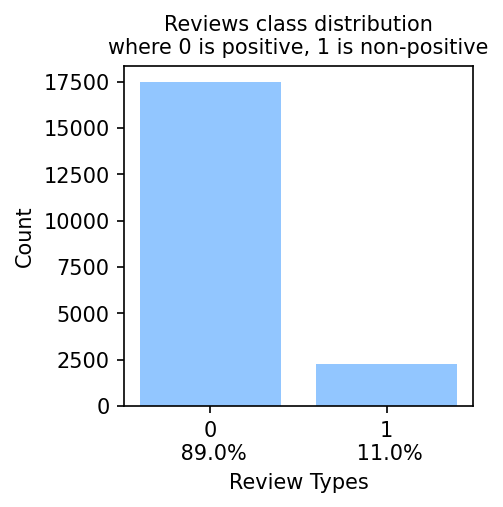

In [66]:
fig, ax = plt.subplots()
ax.bar(binary_class_counts.index, binary_class_counts)
ax.set_xticks([0, 1])
ax.set_xticklabels(binary_class_count_percentage.index.astype(str) + '\n' + ' ' +
                   binary_class_count_percentage.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Review Types')
ax.set_title('Reviews class distribution\nwhere 0 is positive, 1 is non-positive',
              fontsize = 10)
plt.show()

#### Binary Classification- Columns for Preprocessing and Training 

In [67]:
# Picking the only text and target column
df_bi_final = dflog_2_main[['text','target']]

In [68]:
df_bi_final.head()

,text,target
0,"We are visiting in Philadelphia from California. My son took us here for our 28 year wedding anniversary. All the food was delicious and the service was great! Everyone that worked there seemed happy to be there and we're extremely friendly! The pita bread was baked to order and served directly from the oven to the table and was by far, the best I'd had. The hummus, tabbouleh and marinated veggies were all Amazing! The grilled mixed mushrooms and lamb sausage were so flavorful! We didn't have anything that wasn't delicious! If I ever come back to Philly, I would definitely go back to this place! SO GOOD!!",0
1,"Delicious food ! I personally loved it !!!\n\nI was surprised to see 3-star reviews here but when I read it I understood the reason . Everyone loved the place, the food but the prices. Let me tell you something. If I don't want to spend $200 for dinner I don't go to Barkley Prime! If I want to get a good quality lunch I don't expect it to be less than $25. Unfortunately life is expensive here in Philadelphia, especially for people with good tastes. And yes you have to pay $$$ for a good quality meals. So If you are aware of that I'm sure you will totally enjoy SURAYA",0
2,Beautiful place. Excellent food. I only gave it a 2 because they gouge you on the drinks. My manhattan was $16. A very small glass of house wine was $11.50. There is no justification for that. We eat out often in good restaurants. This is the only place that gouges you on the drinks.\nI got the halibut. It was delicious but quite small with nothing on the side.,1
3,"It's extremely overpriced, and the sandwiches are a joke. I love Mediterranean cuisine but this is one of the worst i had. In a city with so many places to eat, i'd expect they would try harder.\n\nService is excellent, though. And the place is really nice",1
4,"Instagram worthy and Claire is an amazing server! \n\nSuraya is super beautiful guys. Nice open space, ceramic tiles, and orange infused water. You enter straight into their bakery/cafe where you can order and sit or you can walk past a little and be seated in their restaurant. I recommend making a reservation because it can get pretty crowded. After a 10 min wait my party of 4 were seated straight away. Their booths are super comfy and bouncy! \n\nClaire came to us shortly after and was super knowledgeable about the menu and helped us navigate for one of our party members who has an allergy. I started with the chai tea latte- so delicious. Then got a kefta platter. Once the food came out I realized it was the kefta sandwich but Claire and the manager figured everything out straight away and fixed my order (thanks guys!). The kefta was super moist, the hummus was A1 and their fries were seasoned to the max. Though I think their tabouli could have more lemon- just my preference though. Afterwards I finished with a rose and pistachio cruller which was so light and airy. Y'all gotta try it. \n\nIf visiting philly again I would definitely come back to Suraya.",0


In [69]:
# applying the cleaning function to text column
df_bi_final['text'] = df_bi_final['text'].apply(lambda text: function_clean(text))

In [70]:
df_bi_final.head(3)

,text,target
0,We are visiting in Philadelphia from California My son took us here for our year wedding anniversary All the food was delicious and the service was great Everyone that worked there seemed happy to be there and we re extremely friendly The pita bread was baked to order and served directly from the oven to the table and was by far the best I d had The hummus tabbouleh and marinated veggies were all Amazing The grilled mixed mushrooms and lamb sausage were so flavorful We didn t have anything that wasn t delicious If I ever come back to Philly I would definitely go back to this place SO GOOD,0
1,Delicious food I personally loved it I was surprised to see star reviews here but when I read it I understood the reason Everyone loved the place the food but the prices Let me tell you something If I don t want to spend for dinner I don t go to Barkley Prime If I want to get a good quality lunch I don t expect it to be less than Unfortunately life is expensive here in Philadelphia especially for people with good tastes And yes you have to pay for a good quality meals So If you are aware of that I m sure you will totally enjoy SURAYA,0
2,Beautiful place Excellent food I only gave it a because they gouge you on the drinks My manhattan was A very small glass of house wine was There is no justification for that We eat out often in good restaurants This is the only place that gouges you on the drinks I got the halibut It was delicious but quite small with nothing on the side,1


### Train Test Split for binary classification<a id='ttsplit_for_binary'>

In [71]:
X_train_2,X_test_2,y_train_2,y_test_2=train_test_split(df_bi_final['text'], df_bi_final['target'], random_state=2,test_size=0.2, stratify = df_bi_final['target'])

In [73]:
type(X_train_2),type(X_test_2), type(y_train_2),type(y_test_2)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [87]:
print("X_train_2 shape :",X_train_2.shape)
print("X_test_2 shape  :",X_test_2.shape)
print("y_train_2 shape :",y_train_2.shape)
print("y_test_2 shape  :",y_test_2.shape)

X_train_2 shape : (15757,)
X_test_2 shape  : (3940,)
y_train_2 shape : (15757,)
y_test_2 shape  : (3940,)


### Binary Classification- Proportion of Target column After train_test_split<a id='bi_target_column_after_ttsplit'>
##### <p style=text-align:left>* [Back to Contents](#contents)</p>

In [74]:
binary_train_class_counts = y_train_2.value_counts()
binary_train_class_counts

0    13967
1     1790
Name: target, dtype: int64

In [76]:
y_train_2.shape

(15757,)

In [77]:
binary_train_class_count_percentages = pd.Series([(x/y_train_2.shape[0])*100.0 for x in binary_train_class_counts])
binary_train_class_count_percentages

0    88.63997
1    11.36003
dtype: float64

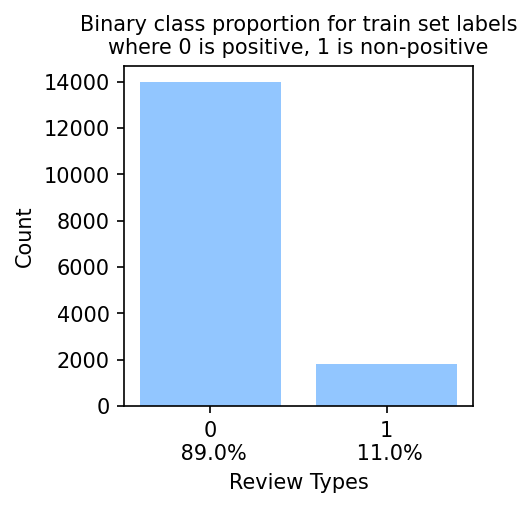

In [81]:
fig, ax = plt.subplots()
ax.bar(binary_train_class_counts.index, binary_train_class_counts)
ax.set_xticks([0, 1])
ax.set_xticklabels(binary_train_class_count_percentages.index.astype(str) + '\n' + ' ' +
                   binary_train_class_count_percentages.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Review Types')
ax.set_title('Binary class proportion for train set labels\nwhere 0 is positive, 1 is non-positive',
              fontsize = 10)
plt.show()

In [75]:
binary_test_class_counts = y_test_2.value_counts()
binary_test_class_counts

0    3492
1     448
Name: target, dtype: int64

In [79]:
y_test_2.shape[0]

3940

In [84]:
binary_test_class_count_percentages = pd.Series([(x/y_test_2.shape[0])*100.0 for x in binary_test_class_counts])
binary_test_class_count_percentages

0    88.629442
1    11.370558
dtype: float64

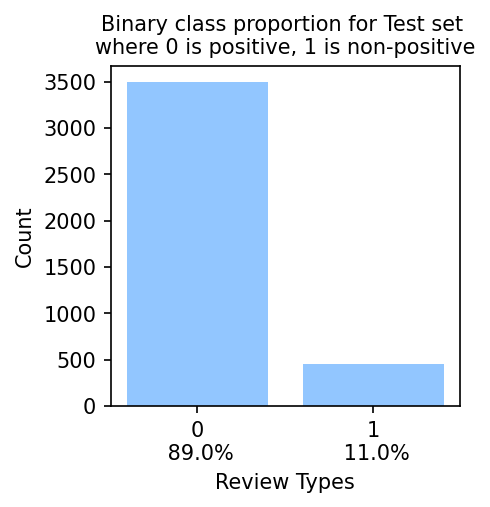

In [85]:
fig, ax = plt.subplots()
ax.bar(binary_test_class_counts.index, binary_test_class_counts)
ax.set_xticks([0, 1])
ax.set_xticklabels(binary_test_class_count_percentages.index.astype(str) + '\n' + ' ' +
                   binary_test_class_count_percentages.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Review Types')
ax.set_title('Binary class proportion for Test set \nwhere 0 is positive, 1 is non-positive',
              fontsize = 10)
plt.show()


In [ ]:
# call tokenize_and_stem function to perform both stemming and tokenization


words_stemmed_2 = tokenize_and_stem(dflog_2_main['text'][1])
print(words_stemmed_2)

In [86]:
# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text

tfidf_2 = TfidfVectorizer(stop_words='english',tokenizer=tokenize_and_stem,ngram_range=(1,1))

In [88]:
X_train_2_transformed = tfidf_2.fit_transform(X_train_2)

In [89]:
type(X_train_2_transformed)


scipy.sparse.csr.csr_matrix

In [90]:
X_test_2_transformed = tfidf_2.transform(X_test_2)

In [91]:
type(X_test_2_transformed)

scipy.sparse.csr.csr_matrix

I want to apply logisticRegression classification algorithm before tackling the imbalance to understand the classification report and the results

In [92]:
# Fitting Logistic regression to the training set
logreg_2 = LogisticRegression()
logreg_2.fit(X_train_2_transformed, y_train_2)

# Predicting the test set results
y_pred_train_2_logreg = logreg_2.predict(X_train_2_transformed)
y_pred_2_logreg = logreg_2.predict(X_test_2_transformed)

# Training score
print(f"Score on training set for binary classes: {logreg_2.score(X_train_2_transformed,y_train_2)}")
print(f"Score on test set for binary classes: {logreg_2.score(X_test_2_transformed,y_test_2)}")


Score on training set for binary classes: 0.9424382813987434
Score on test set for binary classes: 0.9263959390862944


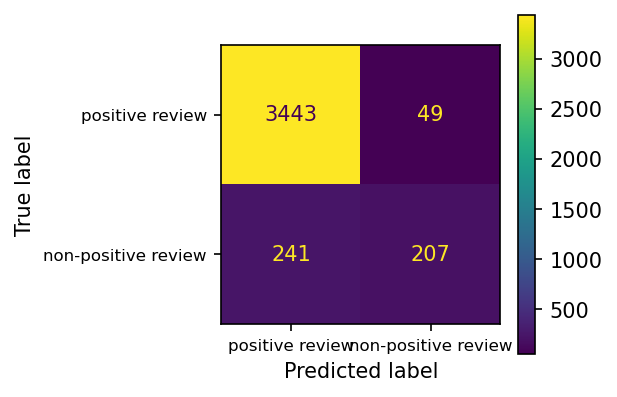

In [93]:
cm_2 = confusion_matrix(y_test_2, y_pred_2_logreg, labels = logreg_2.classes_)
_, ax = plt.subplots()
display_cm_2 = ConfusionMatrixDisplay(confusion_matrix = cm_2, 
                                    display_labels = ['positive review', 'non-positive review'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
ax.set_yticklabels(labels = ['positive review', 'non-positive review'], fontsize = 8)
display_cm_2.plot(ax = ax)

### Binary Classification Report for training set <a id='binary_class_report_training'>

In [94]:
print(classification_report(y_train_2, y_pred_train_2_logreg))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13967
           1       0.91      0.55      0.68      1790

    accuracy                           0.94     15757
   macro avg       0.93      0.77      0.83     15757
weighted avg       0.94      0.94      0.94     15757



### Binary Classification Report for test set <a id='binary_class_report_test'>

In [95]:
print(classification_report(y_test_2, y_pred_2_logreg))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3492
           1       0.81      0.46      0.59       448

    accuracy                           0.93      3940
   macro avg       0.87      0.72      0.77      3940
weighted avg       0.92      0.93      0.92      3940



In [96]:
print(logreg_2.predict(tfidf_2.transform(['Greek salad was so tasty,I loved it'])))

[0]


In [102]:
print(logreg_2.predict(tfidf_2.transform(['bad'])))

[1]


In [106]:
print(logreg_2.predict(tfidf_2.transform(['food was ok'])))

[0]


In [107]:
print(logreg_2.predict(tfidf_2.transform(['Ambience is horrible and chaotic'])))

[1]


### AUC-ROC for Binary Classification<a id='aucroc_binary'>
                         
##### <p style=text-align:left>* [Back to Contents](#contents)</p>

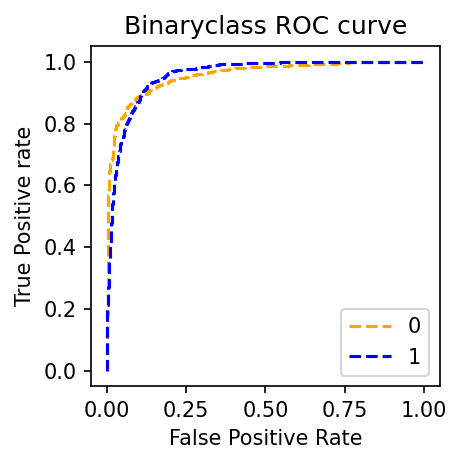

In [108]:
# fit model
clf_b = LogisticRegression()
clf_b.fit(X_train_2_transformed,y_train_2)  
pred_b = clf_b.predict(X_test_2_transformed)
pred_prob_b = clf_b.predict_proba(X_test_2_transformed)


# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_2, pred_prob_b[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='0')
plt.plot(fpr[1], tpr[1], linestyle='--',color='blue', label='1')

plt.title('Binaryclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Binary Class ROC',dpi=300); 

### Area under ROC score for the Binary problem<a id='auc_score_binaryclass'>
                         
##### <p style=text-align:left>* [Back to Contents](#contents)</p>

In [109]:

roc_auc_score(y_test_2,  clf_b.predict_proba(X_test_2_transformed)[:, 1])



0.9573444659221076

### SUMMARIZED CLASSIFICATION REPORTS(Multi-class and Binary class)<a id='summary_reports'>

<table style="background-color: #D6EEEE">
    <tr><th>Model</th><th>classes</th><th>Precision</th><th>Recall</th><th>f1-score</th><th>support</th></tr>
    <tr><td rowspan="3">MultiClass LogReg Training</td><td>0</td><td>0.89</td><td>0.99</td><td>0.94</td><td>12387</td></tr>
    <tr><td>1</td><td>0.86</td><td>0.71</td><td>0.78</td><td>1790</td></tr>
    <tr><td>2</td><td>0.76</td><td>0.25</td><td>0.38</td><td>1580</td></tr>
    <tr><th>accuracy</th><th colspan="4">0.89</th><th>15757</th></tr>
    <tr><td rowspan="3">MultiClass LogReg Test Set</td><td>0</td><td>0.88</td><td>0.99</td><td>0.93</td><td>3097</td></tr>
    <tr><td>1</td><td>0.77</td><td>0.60</td><td>0.67</td><td>448</td></tr>
    <tr><td>2</td><td>0.61</td><td>0.19</td><td>0.29</td><td>395</td></tr>
    <tr><th>accuracy</th><th colspan="4">0.86</th><th>3940</th></tr>
    <tr><td rowspan="2">Binary LogReg Training</td><td>0</td><td>0.95</td><td>0.99</td><td>0.97</td><td>13967</td></tr>
    <tr><td>1</td><td>0.91</td><td>0.55</td><td>0.68</td><td>1790</td></tr>
    <tr><th>accuracy</th><th colspan="4">0.94</th><th>15757</th></tr>
    <tr><td rowspan="2">Binary LogReg Test Set</td><td>0</td><td>0.93</td><td>0.99</td><td>0.96</td><td>3492</td></tr>
    <tr><td>1</td><td>0.81</td><td>0.46</td><td>0.59</td><td>448</td></tr>
    <tr><th>accuracy</th><th colspan="4">0.93</th><th>3940</th></tr>
    </table>

### Summary<a id='summary'>
##### <p style=text-align:left>* [Back to Contents](#contents)</p>

 <b>Logistic Regression</b> is considered as one of the fundamental Machine Learning algorithms associated with classification problems and used as a baseline model. I worked on both the multiclass as well as binary class. Will take this further to apply on other classification models and compare their reports. Will experiment with more hypertuning the parametrs in the next step. 